In [1]:
# Get everything setup for dedicated module loading
%load_ext autoreload
%autoreload 2
from renault.plot import *

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports and Loading data

In [4]:
COLUMN_NAMES = ['Unnamed: 0', 'siteCode', 
                'objectUAI', 'machine', 
                'fluid','measurement',
                'step', 'sourceTimestamp', 
                'pji', 'dataValue',
                'body_type', 'driving_side', 
                'gearbox_type', 'hybrid_level',
                'engine_type']

In [13]:
!ls data/

cleaned_df_ropit.csv extract.csv          train_df_LHA.csv
df_ropit.csv         inference_df_LHA.csv


In [ ]:
# Initial data import and removing of duplicates
df = pd.read_csv('data/cleaned_df_ropit.csv', 
                usecols= COLUMN_NAMES[4:],
                #nrows=4_000_000, 
                #skiprows=range(10_588_994, 10_589_041)
                )
print(df.shape)

df = df.drop_duplicates().sort_values('sourceTimestamp').reset_index(drop=True)
print(df.shape)
df

In [ ]:
#df.to_csv('data/final_df_ropit.csv', index=False )

**IMPORTANT** ~ 20% of duplicated values in the data

**FALSE** 20% percent in the first 1M lines but increases along the file ~50% at 4M Lines, 75% when all file is read

## Analysis of duplication through the whole dataset

In [19]:
data=pd.read_csv('data/cleaned_df_ropit.csv',
                   usecols= COLUMN_NAMES[4:],
                   chunksize=100_000)
base, results = [], []
for chunk in data:
    if len(base) == 0:
        base = chunk.drop_duplicates()
    else:
        base_length = base.shape[0]
        base = pd.concat([base, chunk], axis = 0)
        base = base.drop_duplicates()
        new_length = base.shape[0]
        results.append( 
            [base_length, new_length, (new_length-base_length) / 1000])
    
results = pd.DataFrame(results, columns=['original', 'added_lines', 'precent_variation'])

results['precent_variation'] = (results.added_lines - results.original )/1000

results.rename({'precent_variation': 'percent_original_line_in_100K_chunk'},axis=1, inplace=True)

results.to_csv('data/duplication_percent_in_chunk.csv')

**NOTE:** After 10M lines only 5% of lines are not duplicates, on the ~ 100 missing lines such a percentage is not sufficient to hide defaults on the production line.


## Cleaned data import

In [3]:
# Actual data import
df = pd.read_csv('data/final_df_ropit.csv',index_col='Unnamed: 0')
df

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type
0,FRFluid,ActVacuum,StepPumpPreVacuum,2021-05-11 07:01:00.565 UTC,911412,1,BJI,DG,BVM6,HYB01,H4D
1,FRFluid,ActVacuum,StepPumpPreVacuum,2021-05-11 07:01:15.465 UTC,911412,1,BJI,DG,BVM6,HYB01,H4D
2,RMFluid,ActVacuum,StepVacuum1,2021-05-11 07:01:18.971 UTC,911412,6,BJI,DG,BVM6,HYB01,H4D
3,RMFluid,ActVacuum,StepVacuum1,2021-05-11 07:01:53.272 UTC,911412,63,BJI,DG,BVM6,HYB01,H4D
4,RMFluid,ActVacuum,StepVacuum1,2021-05-11 07:01:53.865 UTC,911412,59,BJI,DG,BVM6,HYB01,H4D
...,...,...,...,...,...,...,...,...,...,...,...
3036862,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.197 UTC,2720139,479,BJI,DG,BVM6,HYB01,H4D
3036863,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.497 UTC,2720139,461,BJI,DG,BVM6,HYB01,H4D
3036864,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.593 UTC,2720139,458,BJI,DG,BVM6,HYB01,H4D
3036865,FRFluid,ActLoadingPressure,StepEndLoading,2021-05-26 23:58:18.796 UTC,2720139,456,BJI,DG,BVM6,HYB01,H4D


# EDA general organization of the data

<AxesSubplot:xlabel='machine', ylabel='Count'>

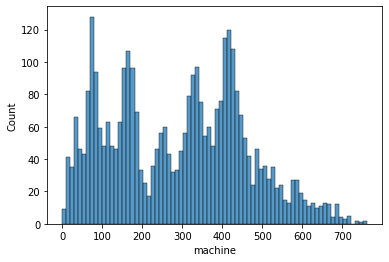

In [24]:
temp = df.groupby('pji').count().reset_index()
sns.histplot(x=temp['machine'], binwidth=10)

## Ananlysis of car types

In [4]:
vehicules = df.loc[:, ['pji', 'body_type','driving_side','gearbox_type','hybrid_level','engine_type']].drop_duplicates()

In [5]:
vehicules.iloc[:, 1:].describe()

,body_type,driving_side,gearbox_type,hybrid_level,engine_type
count,3599,3599,3599,3599,3599
unique,5,2,6,3,8
top,HJD,DG,BVM6,HYB01,H4D
freq,2327,3218,3084,3374,1955


**NOTE:** Percentage of production for the 10 most important models

Sum of this 10 model represent more than 90% of total production

In [34]:
temp = vehicules.groupby(['body_type', 'gearbox_type', 'engine_type', 'driving_side', 'hybrid_level'])[['pji']].\
count(). \
reset_index().\
sort_values('pji', ascending=False) 
#reset_index() 
temp['pji'] = temp.pji / vehicules.shape[0] * 100
car_types = temp.rename(columns={'pji':'percentage_of_production'})
top_cars = car_types.head(10)
top_cars

,body_type,gearbox_type,engine_type,driving_side,hybrid_level,percentage_of_production
6,BJI,BVM6,H4D,DG,HYB01,23.011583
23,HJD,BVM6,K9K,DG,HYB01,21.389961
17,HJD,BVM6,H4D,DG,HYB01,14.851995
20,HJD,BVM6,H5H,DG,HYB01,6.280566
7,BJI,CVTX,H4D,DG,HYB01,4.427284
29,LJI,BVM6,H4D,DG,HYB01,4.015444
16,HJD,BVM6,H4D,DD,HYB01,3.963964
13,HJD,BVM5,H4M,DG,HYB01,3.449163
19,HJD,BVM6,H5H,DD,HYB01,2.651223
21,HJD,BVM6,K9K,DD,HYB01,2.342342


RMQ: The number of lines per vehicule appears to be ~ bimodal. One peak at ~100 and another at ~350

## Plot values for a single vehicule

Randomly select one car based on pji and plot measurement values for each fluid

In [7]:
# Get unique pji far all vehicules
names = pd.Series(df.pji.unique())


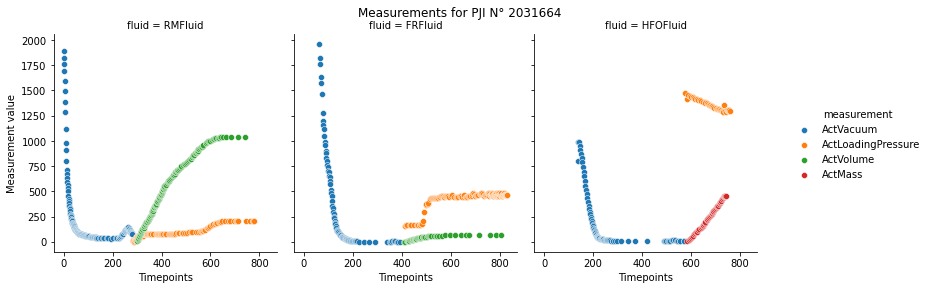

In [8]:
g = plot_all_fluid(df, names.sample(1).iloc[0])


<AxesSubplot:xlabel='index', ylabel='dataValue'>

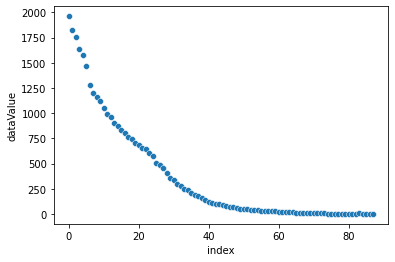

In [11]:
plot_selective_fluid(df, 2031664, 'FRFluid','ActVacuum')



Measurement = 

    - ActLoadingPressure for FR and RM, 
    
    - ActVolume for HFO

QUESTION: Percentage of car with values for all three final loading steps

`
3    83.562520
2    15.190278
1     1.247202`

In [33]:
temp = df[df['step'] == 'StepLoading']\
.groupby(['pji', 'fluid'])[['dataValue']]\
.count()\
.reset_index('fluid')

In [ ]:
temp = temp.groupby('pji')['fluid'].count().value_counts() / temp.index.nunique() * 100

## Changes in measurement values during the different phases

QUESTION: What is the distribution of the measurements for the different fluids ? (Loading phase)

In [ ]:
filling = df[df['measurement'].isin(['ActLoadingPressure', 'ActVolume'])]
temp = filling.groupby(['fluid','pji']) \
    .agg({'dataValue':['min', 'mean', 'median', 'max']})

temp.columns = [n[1] for n in temp.columns]
temp.reset_index(inplace=True)
temp = temp.melt(id_vars=['fluid', 'pji'], value_vars=['min', 'mean', 'median', 'max'])

temp

<AxesSubplot:xlabel='fluid', ylabel='value'>

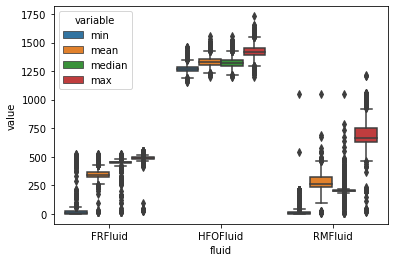

In [114]:
sns.boxplot(data=temp, x='fluid', y='value', hue='variable', showfliers='False')


QUESTION what is the shape of non-working filling for a given car

- FRfluid values < 400 are weird
- HFOFLuid values < 1100 are weird
- RM fluid no patter so far

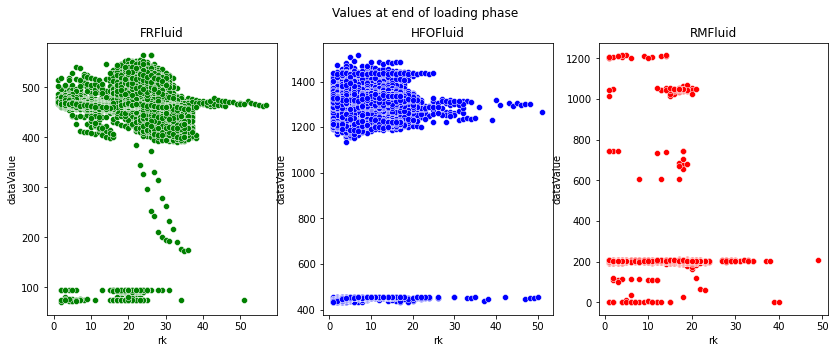

In [14]:
temp = df[df['step'] == 'StepEndLoading'].copy()
temp.sort_values('sourceTimestamp', inplace=True)
temp['rk'] = temp.groupby('pji').cumcount()+1


plot_fluids(temp, x='rk', y='dataValue')
plt.suptitle('Values at end of loading phase');

Text(0.5, 0.98, 'Values during Loading Phase')

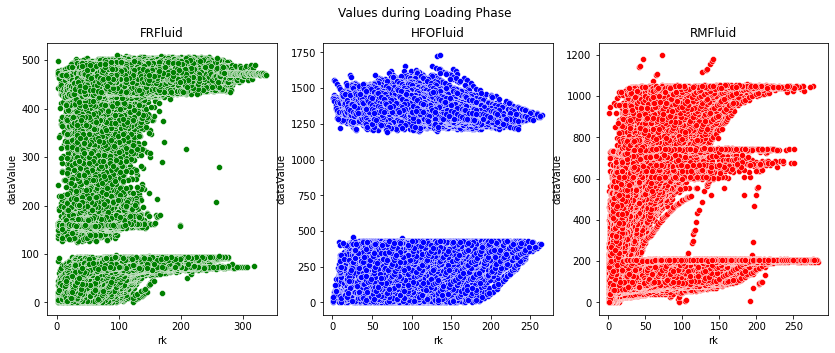

In [105]:
temp = df[df['step'] == 'StepLoading'].copy()
temp.sort_values('sourceTimestamp', inplace=True)
temp['rk'] = temp.groupby('pji').cumcount()+1

plot_fluids(temp, x='rk', y='dataValue')
plt.suptitle('Values during Loading Phase')

## Influences of car type on measurement final value

In [55]:
# Get a list of conditions to filter the 10 main types of cars
condition=[]
for line in range(top_cars.shape[0]):
    string = ''
    for idx in range(top_cars.shape[1]-1):
        string += f'{top_cars.columns[idx]} == "{top_cars.iloc[line, idx]}" & '
    condition.append(string[:-2])
    
condition[0:3]

['body_type == "BJI" & gearbox_type == "BVM6" & engine_type == "H4D" & driving_side == "DG" & hybrid_level == "HYB01" ',
 'body_type == "HJD" & gearbox_type == "BVM6" & engine_type == "K9K" & driving_side == "DG" & hybrid_level == "HYB01" ',
 'body_type == "HJD" & gearbox_type == "BVM6" & engine_type == "H4D" & driving_side == "DG" & hybrid_level == "HYB01" ']

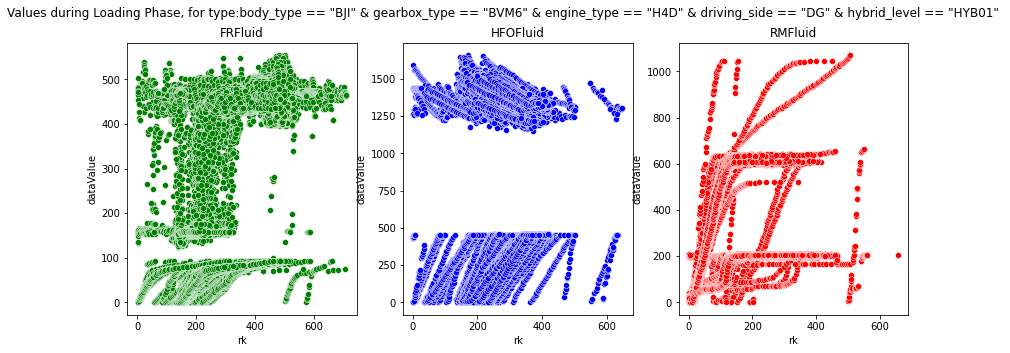

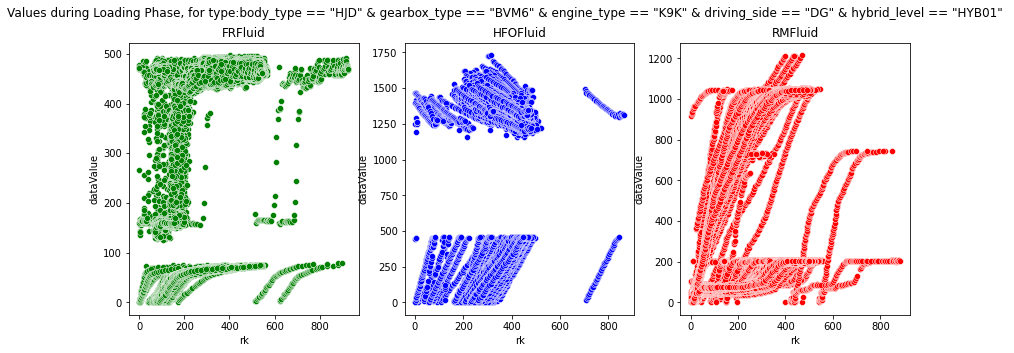

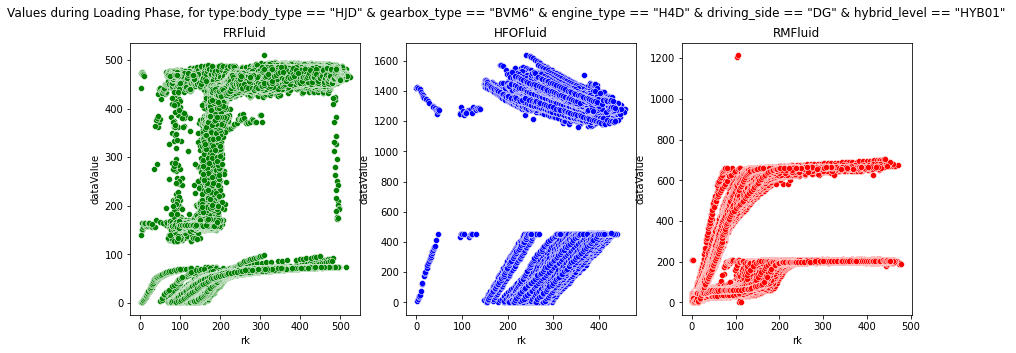

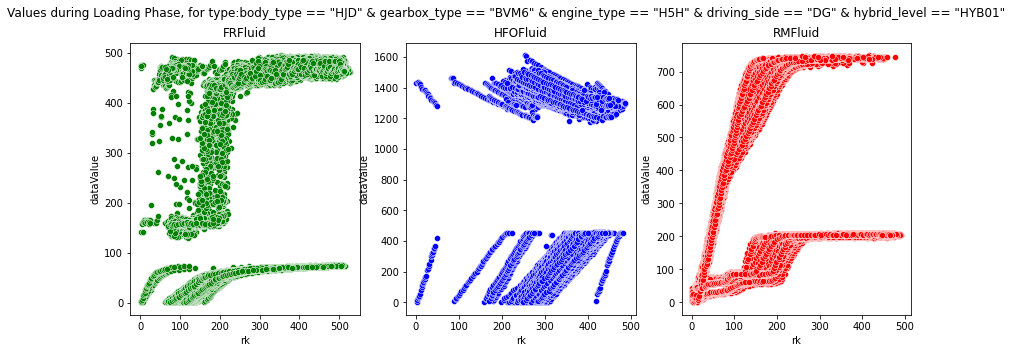

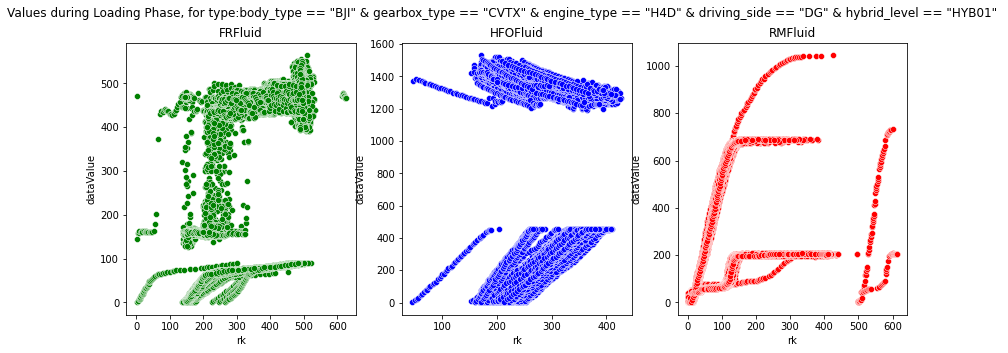

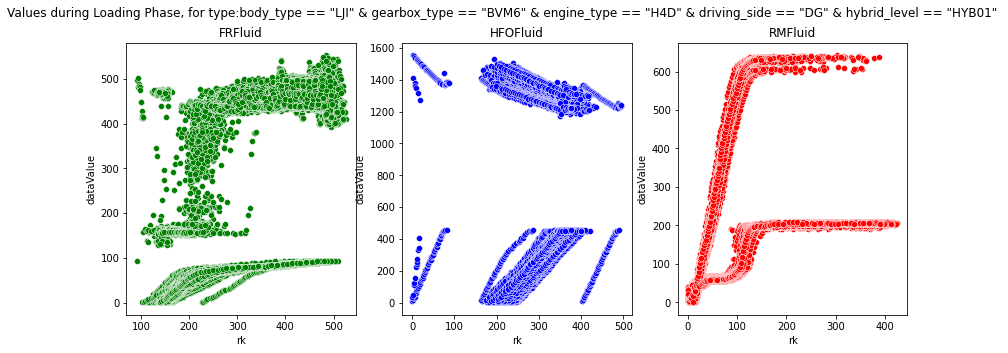

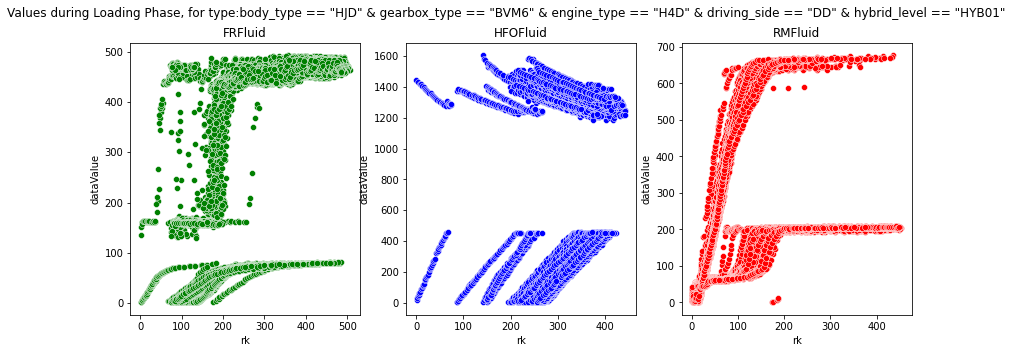

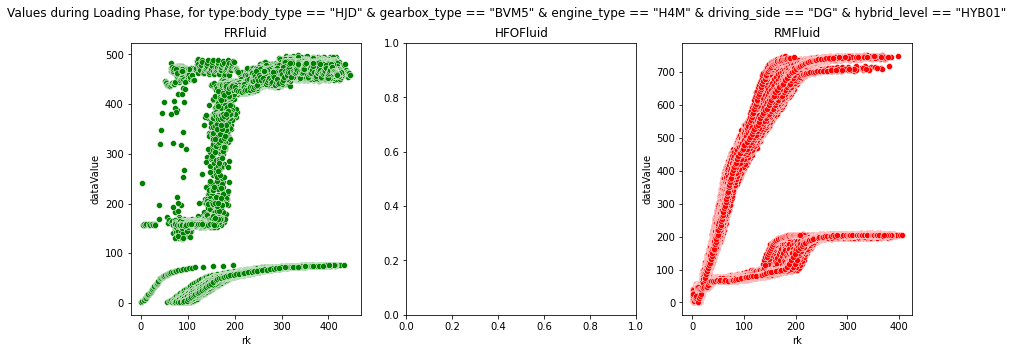

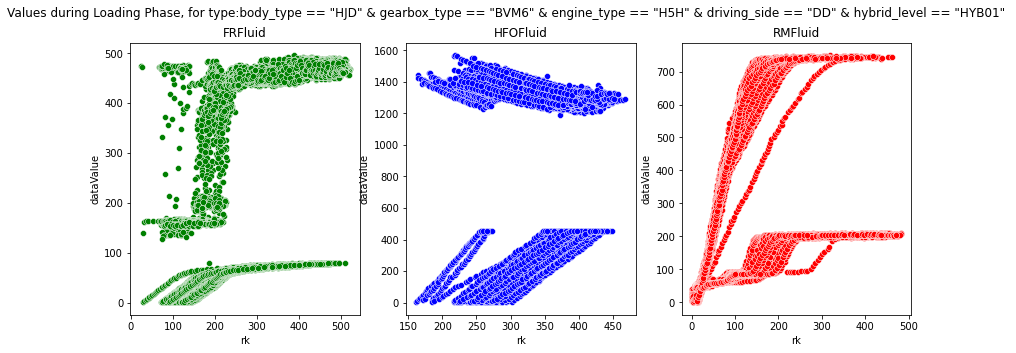

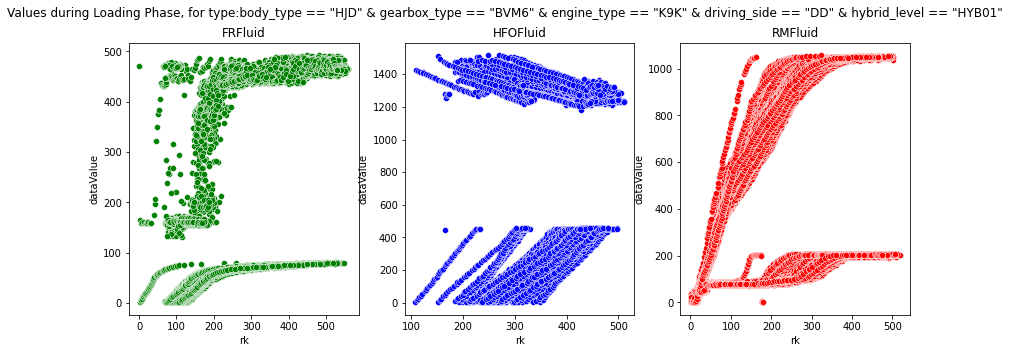

In [60]:
filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']
for cond in condition:
    temp = df[df.step.isin(STEPS)].query(cond).copy()
    temp.sort_values('sourceTimestamp', inplace=True)
    temp['rk'] = temp.groupby('pji').cumcount()+1

    plot_fluids(temp, x='rk', y='dataValue')
    
    plt.suptitle(f'Values during Loading Phase, for type:{cond}')

In [60]:
temp[temp['dataValue'] < 350].select_dtypes(include='object').describe(include='all')

,machine,fluid,measurement,step,sourceTimestamp,body_type,driving_side,gearbox_type,hybrid_level,engine_type
count,192,192,192,192,192,181,181,181,181,181
unique,1,1,2,1,192,3,2,3,2,4
top,FillingStation_2,FRFluid,ActVolume,StepEndLoading,2021-05-11 07:15:18.669 UTC,BJI,DG,BVM6,HYB01,H4D
freq,192,192,187,192,1,102,179,166,180,134


In [8]:
df.measurement.unique()

array(['ActVolume', 'ActMass', 'ActVacuum', 'ActLoadingPressure'],
      dtype=object)

In [13]:
df.shape, df.drop_duplicates().shape

((1000000, 15), (1000000, 15))

**Question:** For a given body type what are there differences in term of volume filling (i.e. different engine volume)

In [12]:
temp = df[df.body_type == 'HJD'].copy()

temp.sort_values('sourceTimestamp', inplace=True)
temp['rk'] = temp.groupby('pji').cumcount()+1
#temp.groupby('pji')['dataValue'].transform(max)

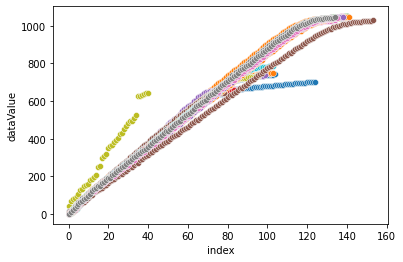

In [13]:
for num in pd.Series(temp.pji.unique()).sample(50):
    plot_selective_fluid(temp,num, 'RMFluid', 'ActVolume')

In [67]:
temp[temp.measurement == 'ActVolume'].groupby(['engine_type', 'step']).agg(
    {'dataValue':['min', 'max', np.median, np.mean],
    'pji': pd.Series.nunique})



dataValue                                pji
                                 min   max  median         mean nunique
engine_type step                                                       
F4R         StepEndLoading      1201  1215  1208.0  1208.000000       1
            StepLoading            0  1193   259.0   324.502736      47
H4D         StepEndLoading        75  1214    75.0   182.800000      53
            StepLoading            1   703   161.0   251.199059     723
H4M         StepEndLoading        72   747    76.0   232.176471      17
            StepLoading            1   800   244.0   311.620364     179
H5H         StepEndLoading        74   745    75.0   158.781250      31
            StepLoading            1   749   236.0   305.771895     346
K9K         StepEndLoading        73  1215    75.0   509.914634     155
            StepLoading            0  1200   368.0   427.738477    1009

In [81]:
steps = df.groupby(['pji', 'fluid', 'measurement'])['step'].nunique().reset_index()

In [93]:
df.groupby(['fluid', 'measurement', 'step'],as_index=False)['pji'].nunique().sort_values(['fluid', 'measurement'])

,fluid,measurement,step,pji
0,FRFluid,ActLoadingPressure,StepEndLoading,3752
1,FRFluid,ActLoadingPressure,StepLoading,3756
2,FRFluid,ActVacuum,StepEndVacuum,3510
3,FRFluid,ActVacuum,StepPumpPreVacuum,3786
4,FRFluid,ActVacuum,StepVacuum1,3771
5,FRFluid,ActVacuum,StepVacuum2,3750
6,FRFluid,ActVacuum,StepVacuumControl,3765
7,FRFluid,ActVolume,StepEndLoading,643
8,FRFluid,ActVolume,StepLoading,3756
9,HFOFluid,ActLoadingPressure,StepEndLoading,3356


Why not all vehicules have StepEndLoading ?

In [100]:
filling = ['ActVolume', 'ActMass']
df[df.measurement.isin(filling)].groupby(['fluid', 'step', 'body_type'],as_index=False).agg(
    {'dataValue': [np.min, np.median, np.mean, np.max],
    'pji':pd.Series.nunique}
)

fluid            step body_type dataValue                             \
                                            amin  median         mean  amax   
0    FRFluid  StepEndLoading       B52        76    76.0    76.000000    76   
1    FRFluid  StepEndLoading       BJI        74    94.0    93.317784    95   
2    FRFluid  StepEndLoading       HJD        72    75.0    75.000000    87   
3    FRFluid  StepEndLoading       LJI        93    94.0    93.883333    94   
4    FRFluid     StepLoading       B52         1    49.0    44.230513    80   
5    FRFluid     StepLoading       BJI         0    60.0    53.849556    99   
6    FRFluid     StepLoading       HJD         0    49.0    43.914057    98   
7    FRFluid     StepLoading       L52         1    48.0    43.575121    76   
8    FRFluid     StepLoading       LJI         1    60.0    54.215198    94   
9   HFOFluid  StepEndLoading       B52       432   452.0   448.591837   456   
10  HFOFluid  StepEndLoading       BJI       432   451.0   447.932188   457   
11  HFOFluid  StepEndLoading       HJD       432   451.0   448.366528   458   
12  HFOFluid  StepEndLoading       LJI       432   451.0   447.796140   456   
13  HFOFluid     StepLoading       B52         0   222.0   218.746667   431   
14  HFOFluid     StepLoading       BJI         0   223.0   220.555516   431   
15  HFOFluid     StepLoading       HJD         0   223.0   220.430057   455   
16  HFOFluid     StepLoading       LJI         1   222.0   219.938725   431   
17   RMFluid  StepEndLoading       BJI       607   631.5   768.833333  1069   
18   RMFluid  StepEndLoading       HJD       670  1047.0  1020.131868  1215   
19   RMFluid     StepLoading       B52         1   358.0   352.004960   666   
20   RMFluid     StepLoading       BJI         1   379.0   367.800007  1059   
21   RMFluid     StepLoading       HJD         1   487.0   491.493303  1200   
22   RMFluid     StepLoading       L52         1   361.0   355.104618   662   
23   RMFluid     StepLoading       LJI         1   378.0   365.467129   688   

       pji  
   nunique  
0        1  
1      343  
2      180  
3       60  
4       31  
5     1015  
6     2260  
7       13  
8      158  
9        9  
10    1042  
11    1900  
12     158  
13       9  
14    1040  
15    1898  
16     159  
17       5  
18      83  
19      33  
20    1044  
21    2287  
22      13  
23     158

# New heading

Very low number of StepEndLoading for RMFluid and FRFluid

In [30]:
temp = df[df.measurement.isin(filling)].groupby(['fluid','pji', 'step', 'measurement'], as_index=False) \
    .agg({'dataValue': 'count'}) \
    .groupby(['fluid',  'measurement','step']) \
    .agg({
        'pji':'count',
        'dataValue':'describe'
    }
    )
temp

pji dataValue                        \
                                      pji     count       mean        std   
fluid    measurement step                                                   
FRFluid  ActVolume   StepEndLoading   643     643.0   1.000000   0.000000   
                     StepLoading     3756    3756.0  52.383387   6.084271   
HFOFluid ActMass     StepEndLoading  3357    3357.0   5.163241   0.865947   
                     StepLoading     3354    3354.0  42.091831   2.676834   
RMFluid  ActVolume   StepEndLoading    95      95.0   1.115789   0.409025   
                     StepLoading     3820    3820.0  97.821466  23.685976   

                                                                     
                                      min   25%   50%    75%    max  
fluid    measurement step                                            
FRFluid  ActVolume   StepEndLoading   1.0   1.0   1.0    1.0    1.0  
                     StepLoading      5.0  48.0  50.0   59.0   99.0  
HFOFluid ActMass     StepEndLoading   1.0   5.0   5.0    6.0   11.0  
                     StepLoading     10.0  41.0  42.0   43.0   78.0  
RMFluid  ActVolume   StepEndLoading   1.0   1.0   1.0    1.0    3.0  
                     StepLoading      1.0  81.0  87.0  107.0  232.0

In [32]:
df[df.measurement.isin(filling)].groupby(['fluid','pji', 'step', 'measurement'], as_index=False) \
    .agg({'dataValue': 'describe'}) \
    .groupby(['fluid',  'measurement','step']) \
    .median()

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


pji dataValue               \
                                                   count         mean   
fluid    measurement step                                               
FRFluid  ActVolume   StepEndLoading  1840398.0       1.0    94.000000   
                     StepLoading     2012419.5      50.0    44.362692   
HFOFluid ActMass     StepEndLoading  2012240.0       5.0   448.142857   
                     StepLoading     2012224.5      42.0   220.383658   
RMFluid  ActVolume   StepEndLoading  1950540.0       1.0  1046.000000   
                     StepLoading     2012417.0      87.0   388.382353   

                                                                           \
                                            std     min       25%     50%   
fluid    measurement step                                                   
FRFluid  ActVolume   StepEndLoading         NaN    94.0    94.000    94.0   
                     StepLoading      22.607833     1.0    26.000    50.0   
HFOFluid ActMass     StepEndLoading    7.106335   436.0   446.000   451.0   
                     StepLoading     125.814702     6.0   116.000   223.0   
RMFluid  ActVolume   StepEndLoading    5.317994  1046.0  1046.000  1046.0   
                     StepLoading     213.028725     5.0   207.125   400.0   

                                                      
                                         75%     max  
fluid    measurement step                             
FRFluid  ActVolume   StepEndLoading    94.00    94.0  
                     StepLoading       63.00    75.0  
HFOFluid ActMass     StepEndLoading   452.50   454.0  
                     StepLoading      326.25   427.0  
RMFluid  ActVolume   StepEndLoading  1046.00  1046.0  
                     StepLoading      589.00   669.0